[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

#Exercise 4.2 Age Prediction from speech

In this exercise we implement a DNN for predicting age of the speaker from speech.

The data comes from the [Accents of the British Isles](http://www.thespeechark.com/abi-2-page.html) corpus. Each speaker read the same short passage, and the audio was processed using the [OpenSMILE](https://www.audeering.com/opensmile/) toolkit into fixed-length vectors of 6373 features. We normalise the features across all speakers using z-scores. We add GENDER as an additional input feature. We convert the speaker AGE into a value between 0-1 and build a network with a linear output to predict age. We plot the predictions as a scatter plot, and calculate correlation and mean absolute error.

---
Set up the environment and load the pre-prepared data from the course website. Run the code.

In [3]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# load a CSV file and divide into feats and labels
def load_csv(filename, outcolname="AGE", featcolstart=4):
  # read CSV file
  df = pd.read_csv(filename, sep=',')
  # convert GENDER column to codes
  gender = pd.Categorical(df['GENDER'])
  # append gender code to audio features
  inputs = np.append(np.array(df.iloc[:, featcolstart:]), np.reshape(gender.codes, (len(df),1)), axis=1)
  # convert age to numpy array
  outputs = df[outcolname].to_numpy()
  # randomise order
  p = np.random.permutation(inputs.shape[0])
  return inputs[p], outputs[p]

# download train and test data
Xtrain, ytrain = load_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_04/age-train.csv.bz2");
Xtest, ytest = load_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_04/age-test.csv.bz2");

# Show counts for the datasets
print("Number of training samples (rows):", Xtrain.shape[0], len(ytrain), sep="\t")
print("Number of test samples (rows)    :", Xtest.shape[0], len(ytest), sep="\t")
print("Number of features (columns)     :", Xtrain.shape[1], Xtest.shape[1], sep="\t")


Number of training samples (rows):	210	210
Number of test samples (rows)    :	52	52
Number of features (columns)     :	6374	6374


---
Normalise the features using [`sklearn`'s preprocessing tools](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). Run the code.

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(Xtrain, ytrain)

# Get feature importance
importance = rf_model.feature_importances_

# Sort the features based on importance
sorted_indices = np.argsort(importance)[::-1]
print("Feature importance:", importance[sorted_indices])

# Select top N features
N = 10
selected_features = sorted_indices[:N]
Xtrain_selected = Xtrain[:, selected_features]
Xtest_selected = Xtest[:, selected_features]


Feature importance: [0.20446537 0.01726905 0.01131777 ... 0.         0.         0.        ]


In [14]:
# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
top_N = 10  # Select top N features (e.g., top 10)
selected_features = sorted_indices[:top_N]
print("Top N Features:", selected_features)


Top N Features: [5981 4875  737 4820 2741 1849 5546 1555 3933 2789]


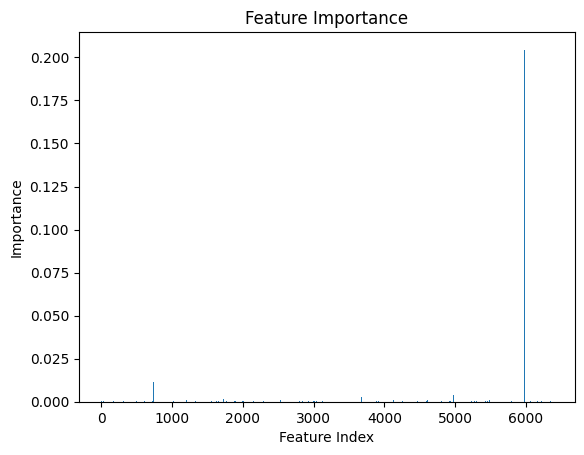

In [15]:
# Plot feature importance
plt.bar(range(len(importance)), importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [4]:
# Get statistics of all features
scaler = StandardScaler().fit(Xtrain)

# Normalise the training and test features
Xtrain_norm = scaler.transform(Xtrain)
Xtest_norm = scaler.transform(Xtest)

# Convert ages to a small number
# Maximum ages in the data are in the 80s
# So outputs should lie well inside the range [0.0, 1.0]
ytrain_norm = ytrain / 100.0
ytest_norm = ytest / 100.0

---
(a) Build a model. Run the code and add comments. Why do we use the `tanh` activation function for the hidden layers? What is the [`Dropout` layer](https://keras.io/api/layers/regularization_layers/dropout/)?

In [17]:
def build_model(input_width, output_width=1):
  model = Sequential()
  # We are using tanh because it
  model.add(Dense(64, activation='tanh', input_shape=(input_width,)))
  # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged.
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(output_width, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
  return model

#(a)
model = build_model(input_width=6374) # Input width = number of features
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │         408,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,113 (1.56 MB)

 Trainable params: 410,113 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

---
(b) Call the `model.fit` method with the correct arguments to train the model with the following specifications: (1) Train for 100 iterations over the dataset; (2) Update the weights during training in batches of 32 samples; (3) Request Keras to randomly select 10% of the training set as the **validation set**.

In [20]:
# Set a threshold for feature importance (e.g., 0.01)
threshold = 0.01

# Get the indices of features with importance above the threshold
selected_features = np.where(importance > threshold)[0]

# Select only the features that have importance above the threshold
Xtrain_selected = Xtrain[:, selected_features]
Xtest_selected = Xtest[:, selected_features]

# Check the new shape after feature selection
print("New number of features in Xtrain_selected:", Xtrain_selected.shape[1])
print("New number of features in Xtest_selected:", Xtest_selected.shape[1])

model = build_model(input_width=Xtrain_selected.shape[1])
training_info_2 = model.fit(Xtrain_selected, ytrain, epochs= 100, batch_size=32, validation_split = 0.1, verbose = False)

New number of features in Xtrain_selected: 5
New number of features in Xtest_selected: 5


In [7]:
training_info = model.fit(Xtrain, ytrain, epochs = 100, batch_size = 32, validation_split = 0.1, verbose=False)

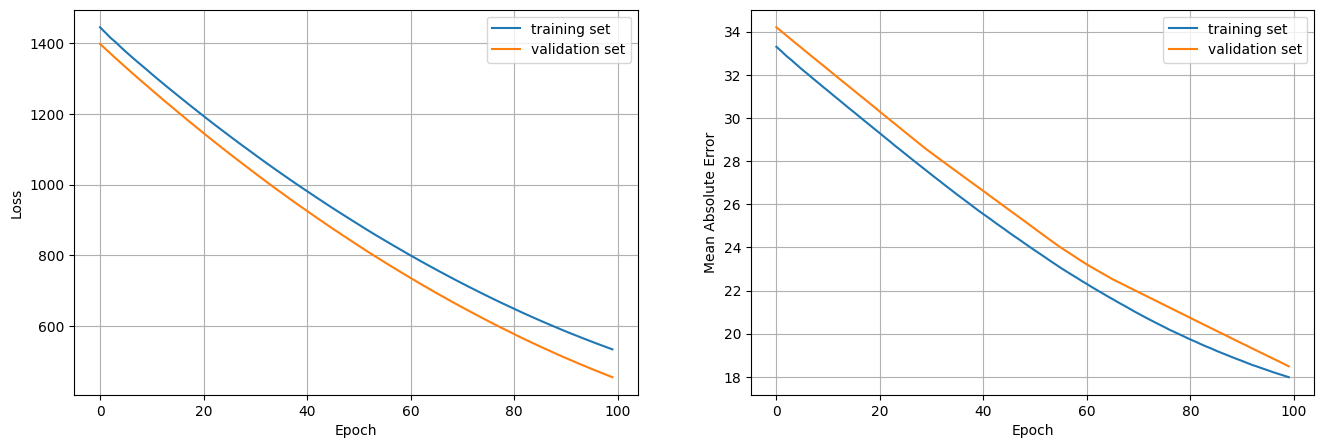

In [8]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['mae'], label="training set")
    axs[1].plot(training_info.history['val_mae'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Mean Absolute Error")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

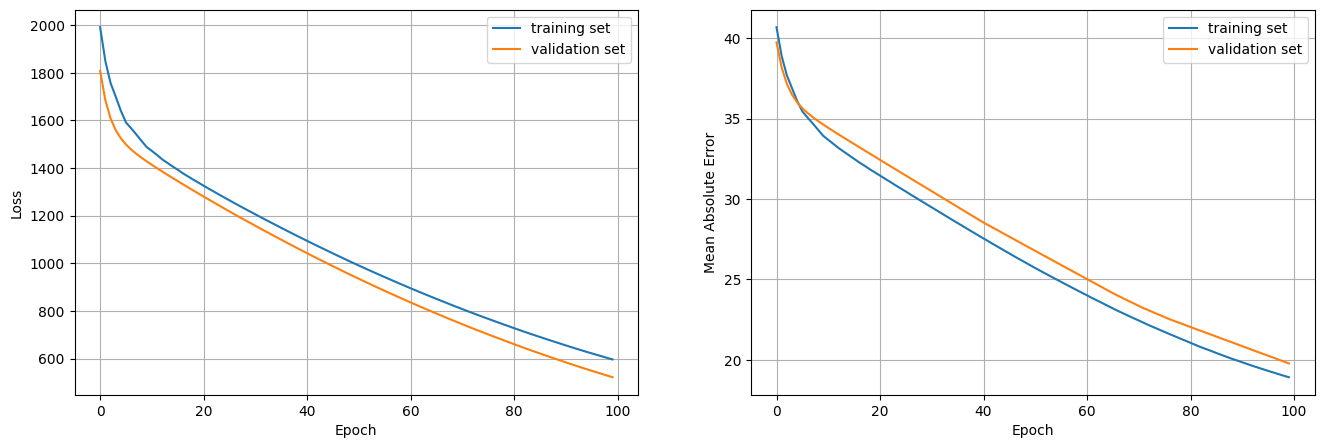

In [21]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['mae'], label="training set")
    axs[1].plot(training_info.history['val_mae'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Mean Absolute Error")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info_2)

(c) Does the process exhibit overfitting or underfitting? Is the performance of the classifier good? Is 100 epochs a reasonable choice? Should the number of epochs be increased or decreased? How could it be that the training error is larger than the validation error?

In [ ]:
#(c)
# Maybe underfitting because we see that the line is continuing to go down and has not stabilised
# I do not see that the training error is larger than the validation error, but they are close

(d) Estimate the generalisation performance of the two models on the test set (use the [model.evaluate method](https://keras.io/api/models/model_training_apis/#evaluate-method). How does the test accuracy compare to those on the validation set?

In [ ]:
#(d)
train_loss, train_accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
test_loss, test_accuracy = model.evaluate(Xtest, ytest, verbose=0)

print("TRAIN SET ACCURACY:", train_accuracy, sep="\t")
print("TEST SET ACCURACY:", test_accuracy, sep="\t")

In [25]:
train_loss_2, train_accuracy_2 = model.evaluate(Xtrain_selected, ytrain, verbose=0)
test_loss_2, test_accuracy_2 = model.evaluate(Xtest_selected, ytest, verbose=0)

print("TRAIN SET ACCURACY:", train_accuracy_2, sep="\t")
print("TEST SET ACCURACY:", test_accuracy_2, sep="\t")

TRAIN SET ACCURACY:	18.946413040161133
TEST SET ACCURACY:	22.860286712646484


---
Plot predictions vs. actual age, run the code.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


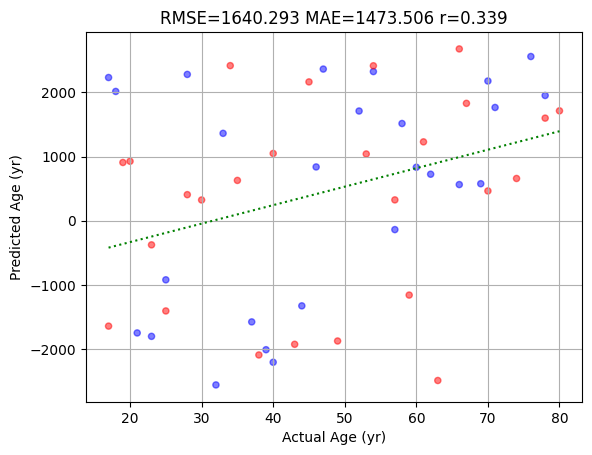

In [12]:
# get predictions of model
ypred_norm = model.predict(Xtest_norm)

# convert back to years
ypred = ypred_norm.flatten() * 100.0

# calculate some statistics
rmse = np.sqrt(np.mean((ytest - ypred) * (ytest - ypred)))
mae = np.mean(np.abs(ytest - ypred))
corr = np.corrcoef(ytest, ypred);

# plot male and female in different colours
colours = ['red', 'blue']
cols = list(colours[int(i)] for i in Xtest[:,Xtest.shape[1] - 1])
# plot a scatter plot
plt.scatter(x=ytest, y=ypred, c=cols, s=20, alpha=0.5);
# calculate a line of best fit
poly = np.polyfit(ytest, ypred, 1)
x = np.array((np.min(ytest), np.max(ytest)))
y = poly[1] + poly[0] * x
plt.plot(x,y,':g')
plt.xlabel("Actual Age (yr)");
plt.ylabel("Predicted Age (yr)");
plt.grid()
plt.title("RMSE=%.3f MAE=%.3f r=%.3f" % (rmse, mae, corr[0, 1]));
plt.show()


---
(e) **Optional**: Experiment with the network to try and improve performance. Some ideas:

- Remove the feature normalisation step - is it useful?
- Change the structure of the network or training regime (advanced) Select a subset of the 6373 features depending on whether the feature has a useful correlation with speaker AGE. Remove features from the training and test sets which do not correlate with age to any useful degree.
- What is the benefit of feature selection here, does it improve the accuracy of the model?
